In [1]:
!gpustat

blade.seas.upenn.edu  Tue Aug 17 14:39:35 2021  455.45.01
[0] RTX A6000        | 29'C,   0 % | 44884 / 48685 MB | wangh19(44881M)
[1] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[2] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[3] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |
[4] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[5] RTX A6000        | 27'C,   0 % |     1 / 48685 MB |
[6] RTX A6000        | 29'C,   0 % |     1 / 48685 MB |
[7] RTX A6000        | 28'C,   0 % |     1 / 48685 MB |


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [3]:
import numpy as onp
from numpy import fft
import jax.numpy as np
from jax import random, grad, vmap, jit, lax
from jax.experimental import optimizers
from jax.experimental.optimizers import make_schedule
from jax.experimental.ode import odeint
from jax.nn import relu, leaky_relu, swish, sigmoid
from jax.config import config

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce 
from jax.flatten_util import ravel_pytree
from jax.ops import index_update, index

from jaxpinns.optimizers import mdmm_adam

import neural_tangents as nt
import operator

from jax.scipy.stats.norm import logpdf, pdf


from tqdm import trange, tqdm

import time
%matplotlib inline
from IPython.display import clear_output

In [4]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                        'lines.linewidth': 2,
                        'axes.labelsize': 10,
                        'axes.titlesize': 16,
                        'xtick.labelsize': 10,
                        'ytick.labelsize': 10,
                        'legend.fontsize': 10,
                        'axes.linewidth': 2})

In [5]:
!ls

0.001_48_bias.npy	    Archive
0.001_48_errors.txt	    before_scaled_angles.pdf
0.001_48_weight.npy	    change_scaled_angles_48.pdf
0.001_8_bias.npy	    change_scaled_angles_64.pdf
0.001_8_errors.txt	    change_scaled_angles_8.pdf
0.001_8_weight.npy	    change_scaled_angles.pdf
32_fit.pdf		    _data_size_errors_32.pdf
32_loss.pdf		    _data_size_target_32.pdf
32_norm.pdf		    _data_size_train_test_errors_32.npy
48_bias_norm.pdf	    _data_size_train_test_errors.npy
48_fit.pdf		    initial.pdf
48_loss.pdf		    max_freq_256_0.0001.npy
48_norm.pdf		    max_freq_256_0.001.npy
64_bias_norm.pdf	    max_freq_256_0.01.npy
64_fit.pdf		    max_freq_256_1e-05.npy
64_loss.pdf		    max_freq_256.npy
64_norm.pdf		    test_l2_256.pdf
8_bias_norm.pdf		    toy_loss_256_0.0001.npy
8_fit.pdf		    toy_loss_256_0.001.npy
8_loss.pdf		    toy_loss_256_0.01.npy
8_norm.pdf		    toy_loss_256_1e-05.npy
after_scaled_angles_48.pdf  toy_loss_256.npy
after_scaled_angles_64.pdf  toy_plot.ipynb
after_scaled_angles_8.pdf 

In [6]:
lam = 0.001
max_freq = 48

In [7]:
weight_norms = np.load(f'{lam}_{max_freq}_weight.npy')
bias_norms = np.load(f'{lam}_{max_freq}_bias.npy')

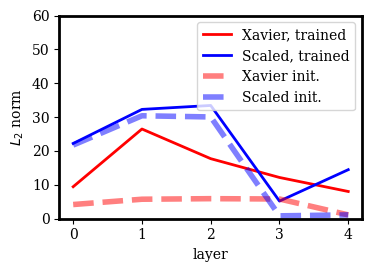

In [12]:
plt.figure(figsize = (4,3))
plt.plot(weight_norms[0], label = 'Xavier, trained', color = 'r')
plt.plot(weight_norms[1], label = 'Scaled, trained', color = 'b')
plt.plot(weight_norms[2], linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.', color = 'r')
plt.plot(weight_norms[3], linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.', color = 'b')
plt.legend(loc = 'upper right')
plt.xlabel('layer')
plt.ylabel(r'$L_2$ norm')
plt.ylim([0, 60])
plt.tight_layout()
plt.savefig(f'{int(max_freq)}_norm.pdf', dpi = 100)
plt.show()
plt.close()

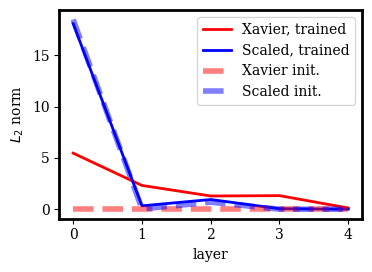

In [11]:
plt.figure(figsize = (4,3))
plt.plot(bias_norms[0], label = 'Xavier, trained', color = 'r')
plt.plot(bias_norms[1], label = 'Scaled, trained', color = 'b')
plt.plot(bias_norms[2], linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Xavier init.', color = 'r')
plt.plot(bias_norms[3], linewidth = 4, alpha = 0.5, linestyle = '--', label = 'Scaled init.', color = 'b')
plt.legend(loc = 'upper right')
plt.xlabel('layer')
plt.ylabel(r'$L_2$ norm')
plt.tight_layout()
plt.savefig(f'{int(max_freq)}_bias_norm.pdf', dpi = 100)
plt.show()
plt.close()